## Focus on Pytorchyfying the code, so that its more like what is noramlly seen syntactically & Exploring Deeper networks

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident, note that we are doing this by shifting the weight in the normalization layer and not the weight of the parameter
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1 this is to make the softmax layer less confident
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # 1 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [28]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # grad * learning rate / data , how fast we update the data

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # we can keep track of how fast we are teaching

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 1.8723


## Effect of the gain (5/3) to counter the "squishing" behaviour of the tanh()

As 5/3 is decreased, there is a squishing effect on the model, although we see that the saturated % is incresing, the std deviation is decreasing, this isnt really good for the model, 

Conversely, when the gain is too big, we overcompensate, causing the model to be mostly saturated, inactive / untrainable

layer 2 (      Tanh): mean -0.00, std 0.69, saturated: 9.59%
layer 5 (      Tanh): mean +0.00, std 0.78, saturated: 23.72%
layer 8 (      Tanh): mean -0.04, std 0.78, saturated: 23.78%
layer 11 (      Tanh): mean -0.00, std 0.79, saturated: 24.41%
layer 14 (      Tanh): mean -0.01, std 0.80, saturated: 22.72%


Text(0.5, 1.0, 'activation distribution')

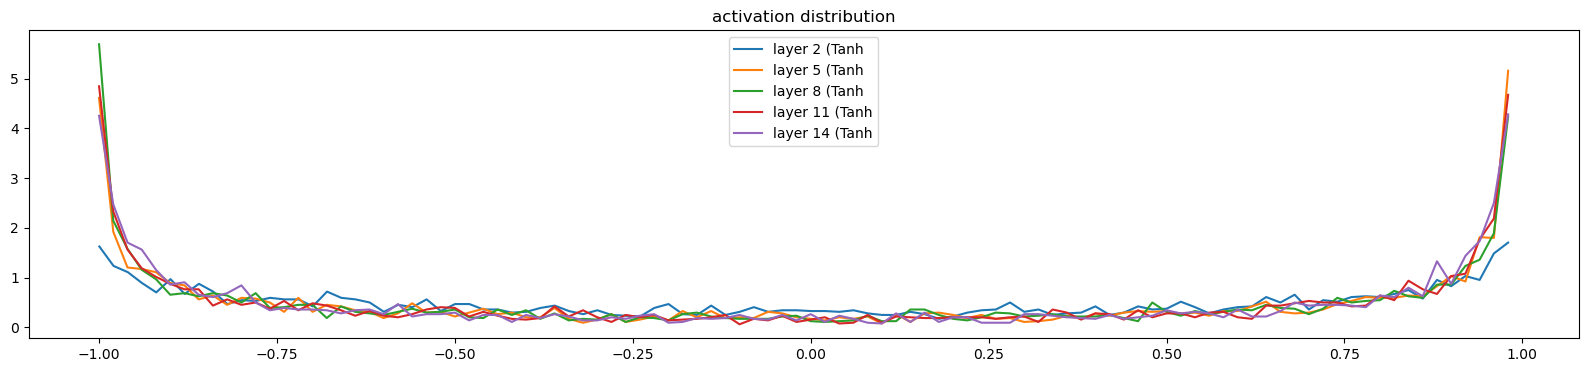

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682952e-03
layer 5 (      Tanh): mean -0.000000, std 3.262607e-03
layer 8 (      Tanh): mean +0.000000, std 2.973730e-03
layer 11 (      Tanh): mean +0.000000, std 2.741109e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

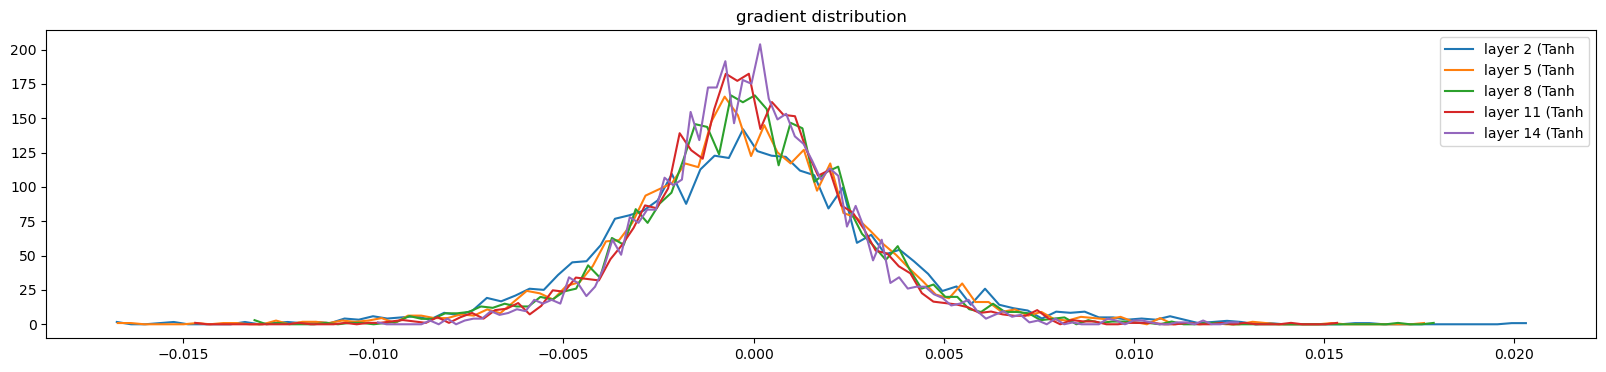

In [8]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000503 | std 1.215225e-02 | grad:data ratio 1.162582e-02
weight  (30, 100) | mean +0.000197 | std 8.478588e-03 | grad:data ratio 2.523437e-02
weight (100, 100) | mean +0.000017 | std 5.558908e-03 | grad:data ratio 2.961683e-02
weight (100, 100) | mean -0.000004 | std 5.286563e-03 | grad:data ratio 2.834835e-02
weight (100, 100) | mean -0.000011 | std 5.165563e-03 | grad:data ratio 2.799306e-02
weight (100, 100) | mean +0.000026 | std 5.090700e-03 | grad:data ratio 2.790354e-02
weight  (100, 27) | mean +0.000217 | std 1.139829e-02 | grad:data ratio 5.643281e-02


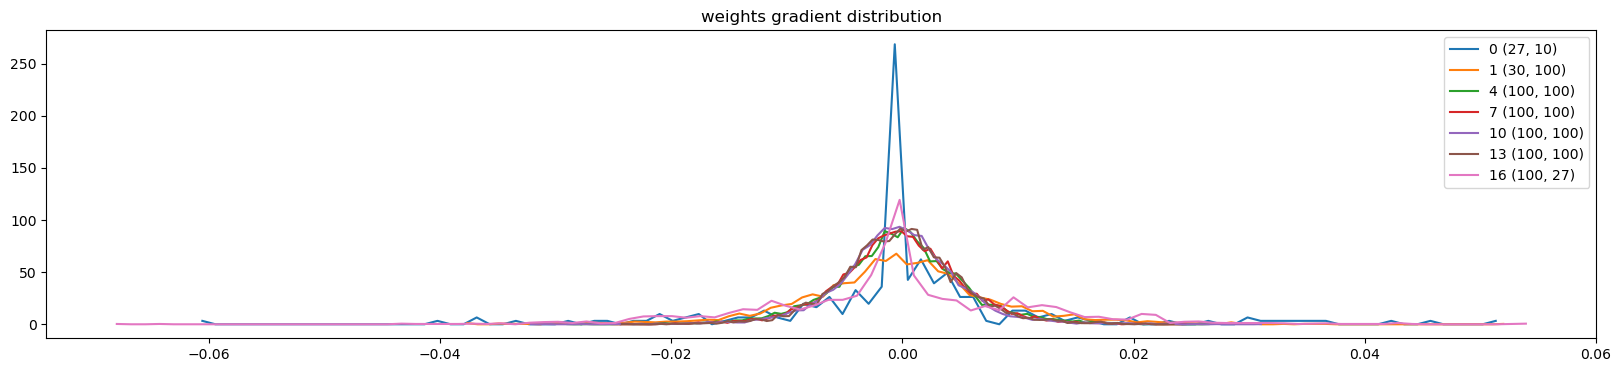

In [30]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

## Cheking how fast we are updating / "teaching" the actual data in the tensors
a good reference value is that we should only be nuding the values by 1/1000 of the actual value, (read the code for ud), 1e-3 is used as a reference due to the log

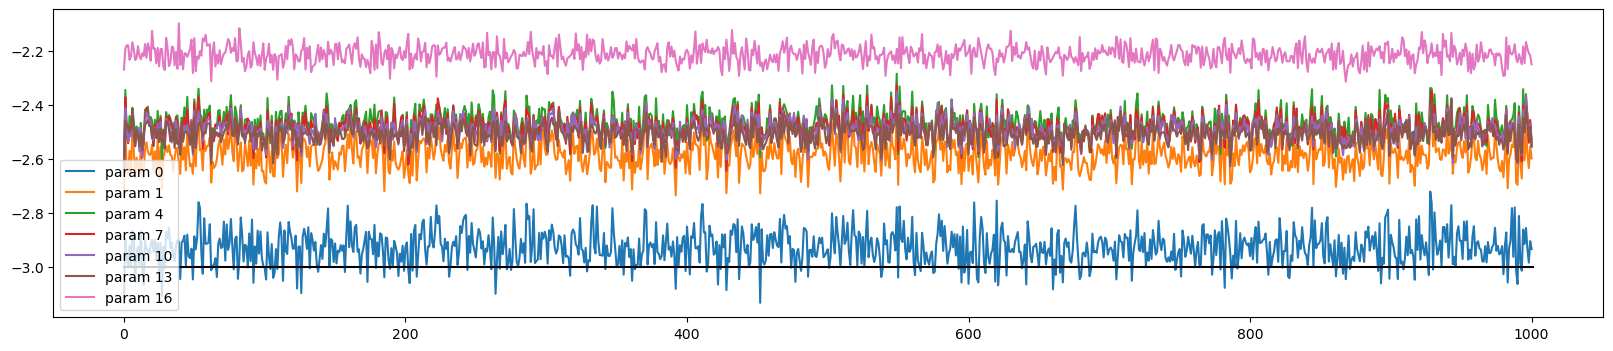

In [31]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [36]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.16526460647583
val 2.1943535804748535


In [37]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amoril.
khi.
mili.
taty.
skanden.
jazhnel.
amerynci.
aqui.
nellara.
chaiivon.
leigh.
ham.
jori.
quint.
suline.
liven.
ara.
elo.
dearixi.


Yes, you’re absolutely correct! Here’s a detailed explanation to validate and build upon your understanding:

1. x0 Representing an Extreme Input

	•	Extreme values for x0 simulate the case where one or more neurons have weights or activations that are unusually large or small (e.g., due to poor initialization, accumulation of errors during training, or outliers in input data).
	•	Since x0 is manually adjusted in this analysis, it acts as a proxy for these extreme scenarios in real-world networks.

2. Ideal Behavior of the Normalization Layer

	•	Normalization layers like BatchNorm are designed to counteract such extreme cases by normalizing the mean and variance of inputs.
	•	When x0 becomes extreme:
	•	It could dominate the computation of the batch mean (xmean) and variance (xvar).
	•	BatchNorm normalizes the data by subtracting xmean and dividing by sqrt(xvar + 1e-5), bringing all values (including extremes) to a standard range.
	•	This stabilization ensures that the downstream layers:
	•	Receive inputs that are not excessively skewed.
	•	Can propagate gradients effectively without vanishing or exploding.

3. Preventing Vanishing or Exploding Gradients

	•	In the backward pass, gradients are proportional to the magnitude of activations in the forward pass. Extreme values can cause:
	•	Vanishing gradients: If activations are too small (e.g., saturating Tanh or Sigmoid), gradients diminish across layers, halting learning.
	•	Exploding gradients: If activations are too large, gradients become excessively large, destabilizing training.
	•	The ideal situation is:
	•	The normalization layer ensures gradients remain within a manageable range, even if extreme values like x0 are present in the input.

4. When Normalization Fails

	•	Normalization may struggle in specific cases:
	1.	Small Batch Sizes:
	•	In small batches, a single extreme value like x0 can dominate the statistics (xmean and xvar), making normalization less effective.
	2.	Outliers That Persist Post-Normalization:
	•	If extreme weights consistently produce large activations across multiple layers, the normalization layer may not fully mitigate the effects, leading to saturation in activation functions.

Conclusion

Yes, x0 becoming extreme can represent cases of poor initialization or weight anomalies in a neuron. The ideal role of the normalization layer is to counteract these extremes, stabilizing both activations and gradients, ensuring the network avoids issues like vanishing or exploding gradients during training. This is critical for the successful training of deep neural networks.

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [14]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [34]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
